In [109]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import LabelEncoder


PATHS = {
    "val_agnostic": "/kaggle/input/shroom-dataset/SHROOM_dev-v2/SHROOM_dev-v2/val.model-agnostic.json",
    "val_aware": "/kaggle/input/shroom-dataset/SHROOM_dev-v2/SHROOM_dev-v2/val.model-aware.v2.json",
    "test_agnostic": "/kaggle/input/shroom-dataset/SHROOM_test-labeled/SHROOM_test-labeled/test.model-agnostic.json",
    "test_aware": "/kaggle/input/shroom-dataset/SHROOM_test-labeled/SHROOM_test-labeled/test.model-aware.json"
}

df_val_agnostic = pd.read_json(PATHS["val_agnostic"])
df_val_aware = pd.read_json(PATHS["val_aware"])
df_test_agnostic = pd.read_json(PATHS["test_agnostic"])
df_test_aware = pd.read_json(PATHS["test_aware"])


df_train = pd.concat([df_test_agnostic, df_test_aware], ignore_index=True)
df_test = pd.concat([df_val_agnostic, df_val_aware], ignore_index=True)

print(f"Combined training set size: {len(df_train)}")
print(f"Combined test set size: {len(df_test)}")

df_train['tgt'] = df_train['tgt'].fillna('')
df_test['tgt'] = df_test['tgt'].fillna('')

def get_reference(row):
    try:
        if row['ref'] == 'src':
            return row['src']
        elif row['ref'] == 'tgt':
            return row['tgt']
        else:
            return str(row['src']) + " " + str(row['tgt'])
    except KeyError:
        return str(row['src']) + " " + str(row['tgt'])

df_train['reference'] = df_train.apply(get_reference, axis=1)
df_test['reference'] = df_test.apply(get_reference, axis=1)
df_train['input_text'] = df_train['hyp'] + " [SEP] " + df_train['reference']
df_test['input_text'] = df_test['hyp'] + " [SEP] " + df_test['reference']

df_train['p_hallucination'] = df_train['p(Hallucination)']
df_test['p_hallucination'] = df_test['p(Hallucination)'] 

label_encoder = LabelEncoder()
df_train['label_encoded'] = label_encoder.fit_transform(df_train['label'])

df_test['label_encoded'] = label_encoder.transform(df_test['label'])

Combined training set size: 3000
Combined test set size: 1000


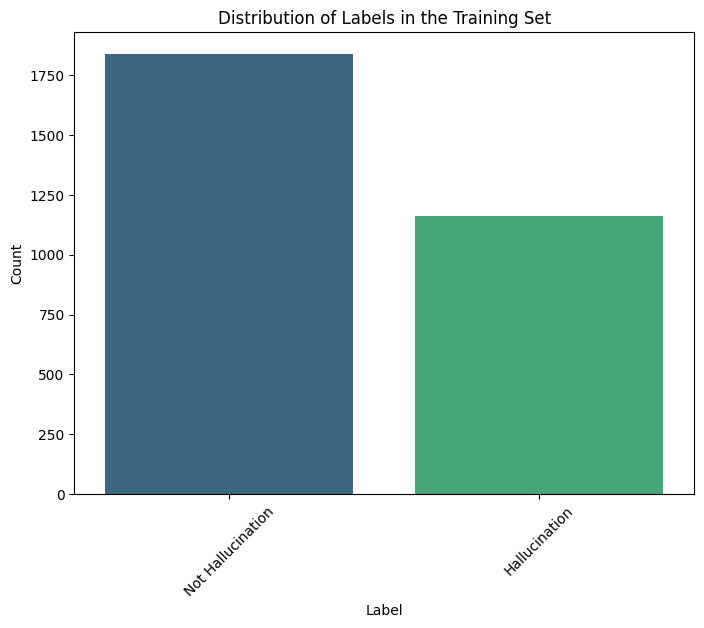


Label distribution:
label
Not Hallucination    1838
Hallucination        1162
Name: count, dtype: int64


In [110]:

plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=df_train, palette='viridis')
plt.title('Distribution of Labels in the Training Set')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


print("\nLabel distribution:")
print(df_train['label'].value_counts())

In [121]:
MAX_LEN = 256
VOCAB_SIZE = 20000

vectorizer = layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_sequence_length=MAX_LEN,
    standardize="lower_and_strip_punctuation"
)
vectorizer.adapt(df_train['input_text'].values)

X_train = vectorizer(df_train['input_text'].values)
X_test = vectorizer(df_test['input_text'].values)
y_train = df_train['label_encoded'].values
y_test = df_test['label_encoded'].values
y_train_prob = df_train['p(Hallucination)'].values
y_test_prob = df_test['p(Hallucination)'].values

print("Data loading, pre-processing, and tokenization complete.")



class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=8, **kwargs):
        super(MultiHeadSelfAttention, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}")
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)
    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs); key = self.key_dense(inputs); value = self.value_dense(inputs)
        query = self.separate_heads(query, batch_size); key = self.separate_heads(key, batch_size); value = self.separate_heads(value, batch_size)
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        attention = tf.matmul(weights, value)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))
        return self.combine_heads(concat_attention)
    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    def get_config(self):
        config = super().get_config(); config.update({'embed_dim': self.embed_dim, 'num_heads': self.num_heads}); return config
    @classmethod
    def from_config(cls, config): return cls(**config)

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.2, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = keras.Sequential([layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim)])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate); self.dropout2 = layers.Dropout(rate)
        self.embed_dim = embed_dim; self.num_heads = num_heads; self.ff_dim = ff_dim; self.rate = rate
    def call(self, inputs, training=False):
        attn_output = self.att(inputs); attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1); ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
    def get_config(self):
        config = super().get_config(); config.update({'embed_dim': self.embed_dim, 'num_heads': self.num_heads, 'ff_dim': self.ff_dim, 'rate': self.rate}); return config
    @classmethod
    def from_config(cls, config): return cls(**config)

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim, **kwargs):
        super(TokenAndPositionEmbedding, self).__init__(**kwargs)
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)
        self.maxlen = maxlen; self.vocab_size = vocab_size; self.embed_dim = embed_dim
    def call(self, x):
        maxlen = tf.shape(x)[-1]; positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions); x = self.token_emb(x)
        return x + positions
    def get_config(self):
        config = super().get_config(); config.update({'maxlen': self.maxlen, 'vocab_size': self.vocab_size, 'embed_dim': self.embed_dim}); return config
    @classmethod
    def from_config(cls, config): return cls(**config)

class StyleMappingNetwork(keras.Model):
    def __init__(self, style_dim, n_layers, **kwargs):
        super().__init__(**kwargs)
        self.style_dim = style_dim; self.n_layers = n_layers
        model_layers = []
        for _ in range(n_layers):
            model_layers.append(layers.Dense(style_dim)); model_layers.append(layers.BatchNormalization()); model_layers.append(layers.LeakyReLU(alpha=0.2))
        self.mapping = keras.Sequential(model_layers)
    def call(self, x): return self.mapping(x)
    def get_config(self):
        config = super().get_config(); config.update({'style_dim': self.style_dim, 'n_layers': self.n_layers}); return config
    @classmethod
    def from_config(cls, config): return cls(**config)

def squash(vectors, axis=-1):
    s_squared_norm = tf.reduce_sum(tf.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm) / tf.sqrt(s_squared_norm + 1e-8)
    return scale * vectors

class CapsuleLayer(layers.Layer):
    def __init__(self, num_capsules, dim_capsule, routings=3, **kwargs):
        super().__init__(**kwargs); self.num_capsules = num_capsules; self.dim_capsule = dim_capsule; self.routings = routings
    def build(self, input_shape):
        self.input_num_capsules = input_shape[1]; self.input_dim_capsule = input_shape[2]
        self.W = self.add_weight(shape=[1, self.input_num_capsules, self.num_capsules, self.dim_capsule, self.input_dim_capsule], initializer='glorot_uniform', name='W')
        self.style_modulator = layers.Dense(self.dim_capsule * 2, name="style_modulator")
    def call(self, inputs, style_vector_w):
        u_hat = tf.squeeze(tf.matmul(self.W, tf.tile(tf.expand_dims(tf.expand_dims(inputs, 2), -1), [1, 1, self.num_capsules, 1, 1])), axis=-1)
        b = tf.zeros(shape=[tf.shape(u_hat)[0], self.input_num_capsules, self.num_capsules, 1])
        for i in range(self.routings):
            c = tf.nn.softmax(b, axis=2); s = tf.reduce_sum(c * u_hat, axis=1, keepdims=True); v = squash(s)
            if i < self.routings - 1: b += tf.reduce_sum(u_hat * v, axis=-1, keepdims=True)
        style_params = self.style_modulator(style_vector_w); style_scale, style_bias = tf.split(style_params, 2, axis=-1)
        v_final = tf.squeeze(v, axis=1); v_modulated = v_final * (tf.expand_dims(style_scale, 1) + 1) + tf.expand_dims(style_bias, 1)
        return v_modulated
    def get_config(self):
        config = super().get_config(); config.update({'num_capsules': self.num_capsules, 'dim_capsule': self.dim_capsule, 'routings': self.routings}); return config
    @classmethod
    def from_config(cls, config): return cls(**config)

class DAC_Net_MultiHead(keras.Model):
    def __init__(self, maxlen, vocab_size, embed_dim=128, num_heads=4, ff_dim=512, num_transformer_blocks=2, style_layers=6, num_hallucination_types=4, capsule_dim=16, **kwargs):
        super().__init__(**kwargs)
        self.maxlen=maxlen; self.vocab_size=vocab_size; self.embed_dim=embed_dim; self.num_heads=num_heads; self.ff_dim=ff_dim; self.num_transformer_blocks=num_transformer_blocks; self.style_layers=style_layers; self.num_hallucination_types=num_hallucination_types; self.capsule_dim=capsule_dim
        self.embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
        self.transformer_blocks = [TransformerBlock(embed_dim, num_heads, ff_dim) for _ in range(num_transformer_blocks)]
        self.style_mapper = StyleMappingNetwork(style_dim=embed_dim, n_layers=style_layers)
        self.primary_capsules_conv = layers.Conv1D(filters=256, kernel_size=9, strides=2, padding='valid', activation='relu')
        self.primary_dim = 8
        self.hallucination_capsules = CapsuleLayer(num_capsules=num_hallucination_types, dim_capsule=capsule_dim)
        self.flatten = layers.Flatten()
        self.binary_classification_head = layers.Dense(2, activation='softmax', name='binary_output')
        self.type_classification_head = layers.Dense(num_hallucination_types, activation='softmax', name='type_output')
        self.prob_regression_head = layers.Dense(1, activation='sigmoid', name='prob_output')
    def call(self, inputs):
        x = self.embedding_layer(inputs)
        for block in self.transformer_blocks: x = block(x)
        sequence_output = x; pooled_output = x[:, 0]
        style_vector_w = self.style_mapper(pooled_output)
        primary_caps_output = self.primary_capsules_conv(sequence_output)
        num_primary_caps = primary_caps_output.shape[1] * (primary_caps_output.shape[2] // self.primary_dim)
        primary_caps_reshaped = layers.Reshape((num_primary_caps, self.primary_dim))(primary_caps_output)
        primary_caps_squashed = squash(primary_caps_reshaped)
        final_capsules = self.hallucination_capsules(primary_caps_squashed, style_vector_w)
        flat_capsules = self.flatten(final_capsules)
        binary_pred = self.binary_classification_head(flat_capsules)
        type_pred = self.type_classification_head(flat_capsules)
        prob_pred = self.prob_regression_head(flat_capsules)
        reasoning_output = final_capsules
        return {'binary_output': binary_pred, 'type_output': type_pred, 'reasoning_output': reasoning_output, 'prob_output': prob_pred}
    def get_config(self):
        config = {"maxlen": self.maxlen, "vocab_size": self.vocab_size, "embed_dim": self.embed_dim, "num_heads": self.num_heads, "ff_dim": self.ff_dim, "num_transformer_blocks": self.num_transformer_blocks, "style_layers": self.style_layers, "num_hallucination_types": self.num_hallucination_types, "capsule_dim": self.capsule_dim}
        base_config = super().get_config(); return {**base_config, **config}
    @classmethod
    def from_config(cls, config): return cls(**config)

print("Model architecture defined.")


In [106]:
MAX_LEN = 256
VOCAB_SIZE = 20000

vectorizer = layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_sequence_length=MAX_LEN,
    standardize="lower_and_strip_punctuation"
)
vectorizer.adapt(df_train['input_text'].values)

X_train = vectorizer(df_train['input_text'].values)
X_test = vectorizer(df_test['input_text'].values)
y_train = df_train['label_encoded'].values
y_test = df_test['label_encoded'].values
y_train_prob = df_train['p(Hallucination)'].values
y_test_prob = df_test['p(Hallucination)'].values

print("Data loading, pre-processing, and tokenization complete.")


class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=8, **kwargs):
        super(MultiHeadSelfAttention, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}")
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)
    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs); key = self.key_dense(inputs); value = self.value_dense(inputs)
        query = self.separate_heads(query, batch_size); key = self.separate_heads(key, batch_size); value = self.separate_heads(value, batch_size)
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        attention = tf.matmul(weights, value)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))
        return self.combine_heads(concat_attention)
    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    def get_config(self):
        config = super().get_config(); config.update({'embed_dim': self.embed_dim, 'num_heads': self.num_heads}); return config
    @classmethod
    def from_config(cls, config): return cls(**config)

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.2, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = keras.Sequential([layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim)])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate); self.dropout2 = layers.Dropout(rate)
        self.embed_dim = embed_dim; self.num_heads = num_heads; self.ff_dim = ff_dim; self.rate = rate
    def call(self, inputs, training=False):
        attn_output = self.att(inputs); attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1); ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
    def get_config(self):
        config = super().get_config(); config.update({'embed_dim': self.embed_dim, 'num_heads': self.num_heads, 'ff_dim': self.ff_dim, 'rate': self.rate}); return config
    @classmethod
    def from_config(cls, config): return cls(**config)

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim, **kwargs):
        super(TokenAndPositionEmbedding, self).__init__(**kwargs)
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)
        self.maxlen = maxlen; self.vocab_size = vocab_size; self.embed_dim = embed_dim
    def call(self, x):
        maxlen = tf.shape(x)[-1]; positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions); x = self.token_emb(x)
        return x + positions
    def get_config(self):
        config = super().get_config(); config.update({'maxlen': self.maxlen, 'vocab_size': self.vocab_size, 'embed_dim': self.embed_dim}); return config
    @classmethod
    def from_config(cls, config): return cls(**config)

class StyleMappingNetwork(layers.Layer): 
    def __init__(self, style_dim, n_layers, **kwargs):
        super().__init__(**kwargs)
        self.style_dim = style_dim; self.n_layers = n_layers
        model_layers = []
        for _ in range(n_layers):
            model_layers.append(layers.Dense(style_dim)); model_layers.append(layers.BatchNormalization()); model_layers.append(layers.LeakyReLU(alpha=0.2))
        self.mapping = keras.Sequential(model_layers)
    def call(self, x): return self.mapping(x)
    def get_config(self):
        config = super().get_config(); config.update({'style_dim': self.style_dim, 'n_layers': self.n_layers}); return config
    @classmethod
    def from_config(cls, config): return cls(**config)

def squash(vectors, axis=-1):
    s_squared_norm = tf.reduce_sum(tf.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm) / tf.sqrt(s_squared_norm + 1e-8)
    return scale * vectors

class CapsuleLayer(layers.Layer):
    def __init__(self, num_capsules, dim_capsule, routings=3, **kwargs):
        super().__init__(**kwargs); self.num_capsules = num_capsules; self.dim_capsule = dim_capsule; self.routings = routings
    def build(self, input_shape):
        self.input_num_capsules = input_shape[1]; self.input_dim_capsule = input_shape[2]
        self.W = self.add_weight(shape=[1, self.input_num_capsules, self.num_capsules, self.dim_capsule, self.input_dim_capsule], initializer='glorot_uniform', name='W')
        self.style_modulator = layers.Dense(self.dim_capsule * 2, name="style_modulator")
    def call(self, inputs, style_vector_w):
        u_hat = tf.squeeze(tf.matmul(self.W, tf.tile(tf.expand_dims(tf.expand_dims(inputs, 2), -1), [1, 1, self.num_capsules, 1, 1])), axis=-1)
        b = tf.zeros(shape=[tf.shape(u_hat)[0], self.input_num_capsules, self.num_capsules, 1])
        for i in range(self.routings):
            c = tf.nn.softmax(b, axis=2); s = tf.reduce_sum(c * u_hat, axis=1, keepdims=True); v = squash(s)
            if i < self.routings - 1: b += tf.reduce_sum(u_hat * v, axis=-1, keepdims=True)
        style_params = self.style_modulator(style_vector_w); style_scale, style_bias = tf.split(style_params, 2, axis=-1)
        v_final = tf.squeeze(v, axis=1); v_modulated = v_final * (tf.expand_dims(style_scale, 1) + 1) + tf.expand_dims(style_bias, 1)
        return v_modulated
    def get_config(self):
        config = super().get_config(); config.update({'num_capsules': self.num_capsules, 'dim_capsule': self.dim_capsule, 'routings': self.routings}); return config
    @classmethod
    def from_config(cls, config): return cls(**config)

class DAC_Net_MultiHead(keras.Model):
    def __init__(self, maxlen, vocab_size, embed_dim=128, num_heads=4, ff_dim=512, num_transformer_blocks=2, style_layers=6, num_hallucination_types=4, capsule_dim=16, **kwargs):
        super().__init__(**kwargs)
        self.maxlen=maxlen; self.vocab_size=vocab_size; self.embed_dim=embed_dim; self.num_heads=num_heads; self.ff_dim=ff_dim; self.num_transformer_blocks=num_transformer_blocks; self.style_layers=style_layers; self.num_hallucination_types=num_hallucination_types; self.capsule_dim=capsule_dim
        self.embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
        self.transformer_blocks = [TransformerBlock(embed_dim, num_heads, ff_dim) for _ in range(num_transformer_blocks)]
        self.style_mapper = StyleMappingNetwork(style_dim=embed_dim, n_layers=style_layers)
        self.primary_capsules_conv = layers.Conv1D(filters=256, kernel_size=9, strides=2, padding='valid', activation='relu')
        self.primary_dim = 8
        self.hallucination_capsules = CapsuleLayer(num_capsules=num_hallucination_types, dim_capsule=capsule_dim)
        self.flatten = layers.Flatten()
        self.binary_classification_head = layers.Dense(2, activation='softmax', name='binary_output')
        self.type_classification_head = layers.Dense(num_hallucination_types, activation='softmax', name='type_output')
        self.prob_regression_head = layers.Dense(1, activation='sigmoid', name='prob_output')
    def call(self, inputs):
        x = self.embedding_layer(inputs)
        for block in self.transformer_blocks: x = block(x)
        sequence_output = x; pooled_output = x[:, 0]
        style_vector_w = self.style_mapper(pooled_output)
        primary_caps_output = self.primary_capsules_conv(sequence_output)
        num_primary_caps = primary_caps_output.shape[1] * (primary_caps_output.shape[2] // self.primary_dim)
        primary_caps_reshaped = layers.Reshape((num_primary_caps, self.primary_dim))(primary_caps_output)
        primary_caps_squashed = squash(primary_caps_reshaped)
        final_capsules = self.hallucination_capsules(primary_caps_squashed, style_vector_w)
        flat_capsules = self.flatten(final_capsules)
        binary_pred = self.binary_classification_head(flat_capsules)
        type_pred = self.type_classification_head(flat_capsules)
        prob_pred = self.prob_regression_head(flat_capsules)
        reasoning_output = final_capsules
        return {'binary_output': binary_pred, 'type_output': type_pred, 'reasoning_output': reasoning_output, 'prob_output': prob_pred}
    def get_config(self):
        config = {"maxlen": self.maxlen, "vocab_size": self.vocab_size, "embed_dim": self.embed_dim, "num_heads": self.num_heads, "ff_dim": self.ff_dim, "num_transformer_blocks": self.num_transformer_blocks, "style_layers": self.style_layers, "num_hallucination_types": self.num_hallucination_types, "capsule_dim": self.capsule_dim}
        base_config = super().get_config(); return {**base_config, **config}
    @classmethod
    def from_config(cls, config): return cls(**config)

print("Model architecture defined.")


Data loading, pre-processing, and tokenization complete.
Model architecture defined.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "dac__net__multi_head_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ token_and_position_embedding_47 │ ?                      │     2,592,768 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_94            │ ?                      │       198,272 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_95            │ ?                      │       198,272 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ style_mapping_network_47        │ ?                      │       102,144 │
│ (StyleMappingNetwork)           │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_47 (Conv1D)              │ (1, 124, 256)          │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capsule_layer_47 (CapsuleLayer) │ ?                      │     2,035,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_47 (Flatten)            │ (1, 64)                │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ binary_output (Dense)           │ (1, 2)                 │           130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ type_output (Dense)             │ (1, 4)                 │           260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ prob_output (Dense)             │ (1, 1)                 │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,422,823 (20.69 MB)

 Trainable params: 5,421,287 (20.68 MB)

 Non-trainable params: 1,536 (6.00 KB)


--- Starting Model Training ---
Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - binary_output_accuracy: 0.5737 - binary_output_loss: 0.6854 - loss: 1.1721 - prob_output_loss: 0.1159 - prob_output_mae: 0.2934 - type_output_loss: 0.7880
Epoch 1: val_binary_output_loss improved from inf to 0.66892, saving model to /kaggle/working/dac_net_multihead_model.keras
85/85 ━━━━━━━━━━━━━━━━━━━━ 38s 162ms/step - binary_output_accuracy: 0.5739 - binary_output_loss: 0.6852 - loss: 1.1715 - prob_output_loss: 0.1159 - prob_output_mae: 0.2934 - type_output_loss: 0.7871 - val_binary_output_accuracy: 0.5903 - val_binary_output_loss: 0.6689 - val_loss: 1.0961 - val_prob_output_loss: 0.1119 - val_prob_output_mae: 0.2924 - val_type_output_loss: 0.6752
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - binary_output_accuracy: 0.6091 - binary_output_loss: 0.6551 - loss: 1.0771 - prob_output_loss: 0.1102 - prob_output_mae: 0.2859 - type_output_loss: 0.6675
Epoch 2: val_binary_output_loss improved from 

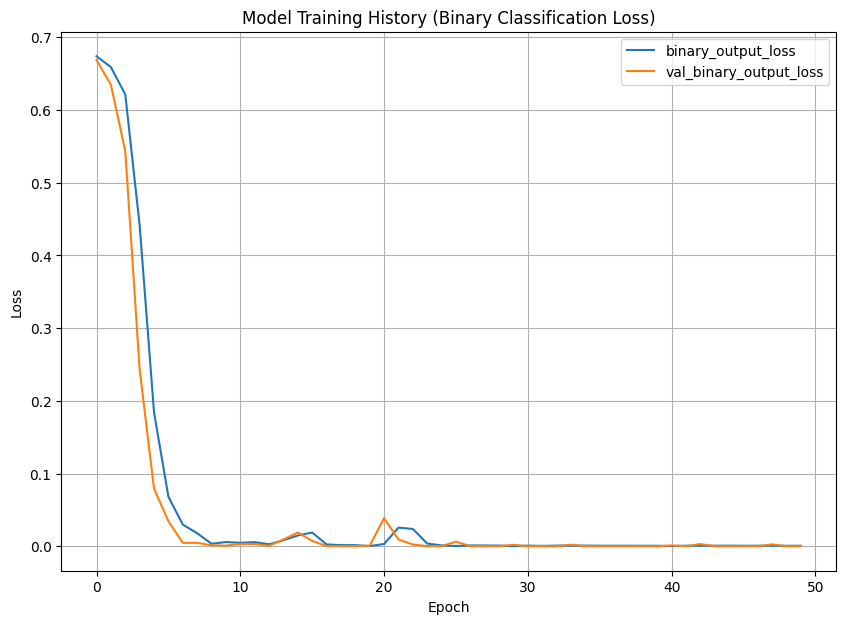

In [107]:
dac_net_multihead = DAC_Net_MultiHead(
    maxlen=MAX_LEN,
    vocab_size=VOCAB_SIZE
)
_ = dac_net_multihead(X_train[:1])
dac_net_multihead.summary()

losses = {
    'binary_output': 'sparse_categorical_crossentropy',
    'type_output': 'sparse_categorical_crossentropy',
    'prob_output': 'mean_squared_error'
}
loss_weights = {'binary_output': 1.0, 'type_output': 0.5, 'prob_output': 0.8}
metrics = {'binary_output': 'accuracy', 'type_output': 'accuracy', 'prob_output': 'mae'}

dac_net_multihead.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss=losses,
    loss_weights=loss_weights,
    metrics=metrics
)

model_checkpoint = ModelCheckpoint(
    filepath='/kaggle/working/dac_net_multihead_model.keras',
    monitor='val_binary_output_loss',
    save_best_only=True,
    verbose=1
)

y_train_dict = {
    'binary_output': y_train,
    'type_output': y_train,
    'prob_output': y_train_prob
}

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train_dict))
train_dataset = train_dataset.shuffle(buffer_size=len(X_train)).batch(32).prefetch(tf.data.AUTOTUNE)

total_batches = tf.data.experimental.cardinality(train_dataset).numpy()
val_batches = max(1, int(total_batches * 0.1))

val_dataset = train_dataset.take(val_batches)
train_dataset = train_dataset.skip(val_batches)


print("\n--- Starting Model Training ---")
history = dac_net_multihead.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=[model_checkpoint]
)

print("\n--- Model Training Finished ---")
print(f"Best model saved to {model_checkpoint.filepath}")

pd.DataFrame(history.history).plot(y=['binary_output_loss', 'val_binary_output_loss'], figsize=(10, 7))
plt.title("Model Training History (Binary Classification Loss)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()



--- Loading best model from checkpoint ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model loaded successfully.

--- Evaluating Model on Test Data ---
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step
Test Accuracy: 0.5580

Classification Report (Binary):
                   precision    recall  f1-score   support

Not Hallucination       0.47      0.39      0.43       424
    Hallucination       0.60      0.68      0.64       576

         accuracy                           0.56      1000
        macro avg       0.54      0.54      0.53      1000
     weighted avg       0.55      0.56      0.55      1000


Area Under Curve (AUC): 0.5574
Correlation with p(Hallucination): -0.1127


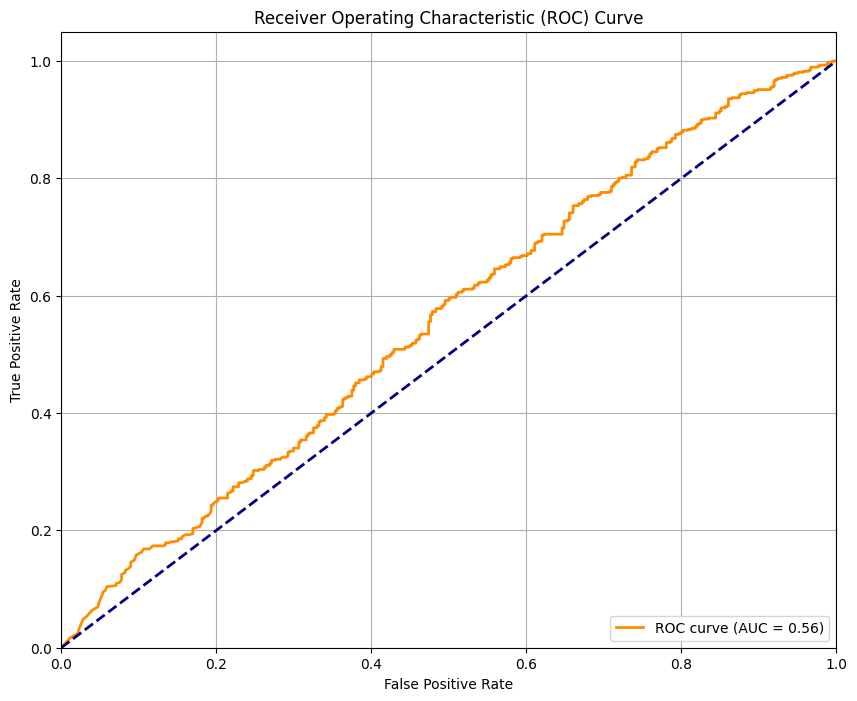

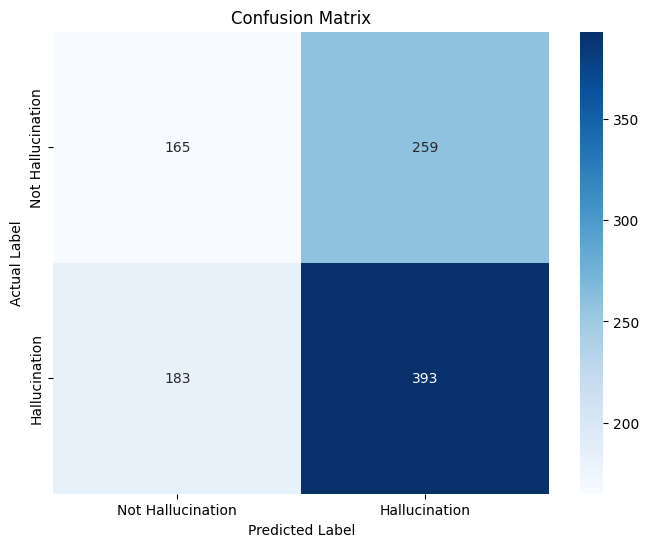



--- Qualitative Analysis of a Single Prediction ---
Hypothesis: '(anatomy) The act or process of preejection.'
Reference: 'Occurring prior to ejection.'
--------------------
True Label: Hallucination (p=0.80)
Predicted Binary Classification: Hallucination (p=1.00)
Predicted Type of Hallucination: Factual

Raw Reasoning Vectors (Capsule Outputs):
[[ 1.579681    0.35215902  1.8616196   1.1471043   3.2651243   0.53750956
  -0.11843406  3.8640428  -4.244648    0.5692409  -1.0011777   1.4108675
  -1.7499104  -0.3944591  -2.9543204   2.4414232 ]
 [ 1.6632637   0.34603086  2.2944207   1.2419044   2.1693163   0.5740536
  -0.03284916  3.6737585  -5.7845144   0.4441581  -1.2100258   0.07954299
  -1.9334394  -0.30383378 -2.8743293   2.1602347 ]
 [ 1.6535583   1.1596613   2.4543025   1.0383343   1.6903255   0.33341253
  -0.00940968  2.8363056  -5.5455565   0.42132452 -1.2176054  -0.45107847
  -1.4972973  -0.39162067 -2.8484538  -0.7778856 ]
 [ 1.3593773   1.1920803   2.7082212   1.2666758   3.53

In [147]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, accuracy_score

custom_objects = {
    "MultiHeadSelfAttention": MultiHeadSelfAttention,
    "TransformerBlock": TransformerBlock,
    "TokenAndPositionEmbedding": TokenAndPositionEmbedding,
    "StyleMappingNetwork": StyleMappingNetwork,
    "CapsuleLayer": CapsuleLayer,
    "squash": squash,
    "DAC_Net_MultiHead": DAC_Net_MultiHead
}

print("--- Loading best model from checkpoint ---")

model_path = '/kaggle/working/dac_net_multihead_model.keras'


loaded_model = keras.models.load_model(
    model_path,
    custom_objects=custom_objects
)
print("Model loaded successfully.")

print("\n--- Evaluating Model on Test Data ---")

predictions_dict = loaded_model.predict(X_test)

binary_predictions_probs = predictions_dict['binary_output']
pred_probs_hallucination = binary_predictions_probs[:, 1]
binary_predictions_labels = np.argmax(binary_predictions_probs, axis=1)

type_predictions_probs = predictions_dict['type_output']
type_predictions_labels = np.argmax(type_predictions_probs, axis=1)

accuracy = accuracy_score(y_test, binary_predictions_labels)
print(f"Test Accuracy: {accuracy:.4f}")

print("\nClassification Report (Binary):")
print(classification_report(y_test, binary_predictions_labels, target_names=['Not Hallucination', 'Hallucination']))

fpr, tpr, thresholds = roc_curve(y_test, pred_probs_hallucination)
roc_auc = auc(fpr, tpr)

print(f"\nArea Under Curve (AUC): {roc_auc:.4f}")

y_test_prob = df_test['p_hallucination'].values
correlation = np.corrcoef(y_test_prob, pred_probs_hallucination)[0, 1]
print(f"Correlation with p(Hallucination): {correlation:.4f}")

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

cm = confusion_matrix(y_test, binary_predictions_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Hallucination', 'Hallucination'], yticklabels=['Not Hallucination', 'Hallucination'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()


print("\n\n--- Qualitative Analysis of a Single Prediction ---")

sample_index = 45 # You can change this index to see different examples

sample_hyp = df_test['hyp'].iloc[sample_index]
sample_ref = df_test['reference'].iloc[sample_index]
true_label_name = df_test['label'].iloc[sample_index]
true_prob = df_test['p_hallucination'].iloc[sample_index]

predicted_binary_prob = pred_probs_hallucination[sample_index]
predicted_binary_label = binary_predictions_labels[sample_index]
predicted_type_label_index = type_predictions_labels[sample_index]
reasoning_vectors = predictions_dict['reasoning_output'][sample_index]

type_map = {0: "Not Hallucination", 1: "Factual", 2: "Logical", 3: "Semantic"}
predicted_type = type_map.get(predicted_type_label_index, "Unknown")

binary_classification_str = "Hallucination" if predicted_binary_label == 1 else "Not Hallucination"


print(f"Hypothesis: '{sample_hyp}'")
print(f"Reference: '{sample_ref}'")
print("-" * 20)
print(f"True Label: {true_label_name} (p={true_prob:.2f})")
print(f"Predicted Binary Classification: {binary_classification_str} (p={predicted_binary_prob:.2f})")
print(f"Predicted Type of Hallucination: {predicted_type}")
print("\nRaw Reasoning Vectors (Capsule Outputs):")
print(reasoning_vectors)